### Evaluation ###

Finally, it's time to test out the user scenarios on the completed agent and see how it does. Let's activate the agent and then get testing!

In [2]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal
from langchain.agents import AgentExecutor, create_openai_tools_agent, load_tools
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
import urllib
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.func import entrypoint, task
from pydantic import BaseModel, ValidationError

from IPython.display import Image, display
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool

import gradio as gr
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain.globals import set_debug

import json

from dotenv import load_dotenv
_ = load_dotenv()

set_debug(False)

In [3]:
## Selecting LLM - I'm using gpt-4
llm = ChatOpenAI(model="gpt-4")

# Reading in BCBS plan brochure
loader = PyPDFLoader("bcbs_brochure.pdf")
docs = loader.load()

embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()

# Define tools
# Tool 1: Internet search
search = DuckDuckGoSearchRun()

# Tool 2: reading the BCBS brochure 
rag = create_retriever_tool(
    retriever=retriever,
    name="document_rag",
    description=""" Answers questions using the content of bcbs_brochure.pdf. 
    It contains information about Blue Cross Blue Shield healthcare plans.
    """
)

# Augment the LLM with tools
tools = [search, rag]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

agent_prompt = '''

You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthcare system questions:
   - Use DuckDuckGo or retrieved documents to explain things like deductibles, coinsurance, Medicaid, open enrollment, etc.

Capabilities:
 - Reference documents to support answers.
 - Use RAG and web search when needed.
 - Stay on topic.
 - Match the user’s tone (e.g. formal, casual, anxious, confident).
 - Be patient, thorough, and nonjudgmental.

Always start by gently asking what kind of help the user wants. Let them guide the depth of the conversation.

Rule: YOU WILL ONLY TALK ABOUT HEALTHCARE.

Rule: YOU WILL ONLY ASK ONE QUESTION AT A TIME, WAITING FOR THE USER TO RESPOND UNTIL ASKING THE NEXT ONE.
'''

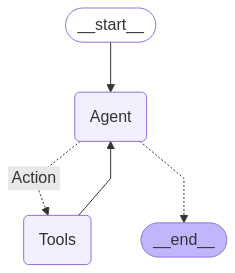

In [4]:
# Define the agent 
def Agent(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content= agent_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["Tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("Agent", Agent)
agent_builder.add_node("Tools", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "Agent")
agent_builder.add_conditional_edges(
    "Agent",
    should_continue,
    {
        "Action": "Tools",
        END: END,
    },
)
agent_builder.add_edge("Tools", "Agent")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

def chat_fn(message, history):

    print(f'----\n{message}\n----\n{json.dumps(history,indent=4)}')
    response = chain.invoke(
        {"input": message, "chat_history": history}
    )
    return response

def chat_fn(messages, history):    
    print(f"--- Turn Start ---")
    print(f"Gradio messages: {messages}")
    print(f"Gradio history: {json.dumps(history, indent=2)}") # Pretty print history

    user_input = messages

    chat_history = [HumanMessage(m["content"]) if m["role"] == "user" else AIMessage(m["content"]) for m in history]

    result = agent.invoke({"messages": chat_history + [HumanMessage(user_input)]})

    assistant_message = result["messages"][-1].content
    return assistant_message

app = gr.ChatInterface(
    fn=chat_fn,
    type="messages"
)

#### User Scenario 1: The Full Experience ####

In [5]:
app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://19a0966ae37247d49c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: Hi! Can you help me pick an insurance plan? 
Gradio history: []
--- Turn Start ---
Gradio messages: I am 50 years old and have several pretty complicated skin issues. 
Gradio history: [
  {
    "role": "user",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "Hi! Can you help me pick an insurance plan? ",
    "options": null
  },
  {
    "role": "assistant",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "Of course! I'll be happy to assist you in picking an insurance plan. \n\nFirst, could you give me some basic information? It would be helpful to know your age, if you have any ongoing medical conditions, and how often you generally need medical attention. This will help us estimate your potential healthcare usage for the next year.",
    "options": nu

##### Analysis #####

The Agent did pretty well! An area of improvement would be if the output specified that it's important to know the premiums associated with each plan when making the final decision. That being said, I'm really happy with how brief (and emoji-less) this output is. It also is doing a good job of asking only one question at a time.

#### User Scenario 2: General Healthcare Questions ####

In [5]:
app.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://737d1e8d95938324f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: What is the difference between a PPO and HMO plan?
Gradio history: []
--- Turn Start ---
Gradio messages: Ok, does the HMO plan my employer offers in the provided brochure require referrals to see a specialist? 
Gradio history: [
  {
    "role": "user",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "What is the difference between a PPO and HMO plan?",
    "options": null
  },
  {
    "role": "assistant",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "The main differences between PPO (Preferred Provider Organization) and HMO (Health Maintenance Organization) health insurance plans are about costs, provider networks, out-of-network care and referrals. Here are some common distinctions:\n\n1. **Network of providers**: Both types of insurance work with

##### Analysis #####

This output looks good to me! It appears that the Agent referenced both the internet and the provided document in a single conversation. I also appreciated that it elaborated about what healthcare plans where you don't need a referral to see a specialist are like. 

#### User Scenario 3: Specific Plan Questions ####

In [7]:
app.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://737d1e8d95938324f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: How much would the copay be for an urgent care visit? You have my plan brochure. 
Gradio history: []
--- Turn Start ---
Gradio messages: I have my Blue Access PPO Silver 7000
Gradio history: [
  {
    "role": "user",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "How much would the copay be for an urgent care visit? You have my plan brochure. ",
    "options": null
  },
  {
    "role": "assistant",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "The copay for an urgent care visit differs depending on your specific plan. Here are some examples from the brochure:\n\n- Bronze 3800: $100 copay\n- Silver 7000 and 3500, Premier Silver 0: $100 copay\n- Extra Savings Silver (income level 150-199% FPL): $10 copay\n- Extra Savings Silver (income level 200-249

##### Analysis #####

The Agent did pretty well! The numbers it retrieved for the 2 plans I specified were correct. I think the caveats about premiums and deductibles were helpful. 

#### Bonus: Seeing if doctors are in network ####

In [11]:
app.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://737d1e8d95938324f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: Does Raza Ahmad, MD accept blue cross blue shield insurance? 
Gradio history: []


Yay!

#### Bonus 2: Distractions ####

In [12]:
app.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://737d1e8d95938324f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: What is the most popular dog breed in the US? 
Gradio history: []
--- Turn Start ---
Gradio messages: Dogs support my mental health! 
Gradio history: [
  {
    "role": "user",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "What is the most popular dog breed in the US? ",
    "options": null
  },
  {
    "role": "assistant",
    "metadata": {
      "title": null,
      "id": null,
      "parent_id": null,
      "duration": null,
      "status": null
    },
    "content": "I'm sorry for any confusion, but I can only provide information related to healthcare. I'm designed to help users navigate the complex U.S. healthcare system. If you have questions about health plans, insurance policies, healthcare terms, and such, feel free to ask!",
    "options": null
  }
]
--- Turn Start ---
Gradio messages: What color collar looks best on  a golden retriever?
G

Ha! I wasn't expecting the topic pivot for talking about healthcare plans for dogs. Good work, HealthPlan Helper.